### Keras - Predictions and Transfer Learning

We start by using a model to make some predictions in our test data. 
This model, which is ResNet50 is  already trained on ImageNet Data set

In [3]:
import keras 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50, decode_predictions
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
import argparse
from keras.applications.vgg19 import preprocess_input

In [2]:
preprocessing_function = preprocess_input
base_model = ResNet50()

In [3]:
image = load_img('/c/Users/yfakihan/workspace/POC/POC1/car_dataset/cars_test/sony.jpg', target_size=(224, 224))

    
base_model.summary()
    
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = base_model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

seat_belt (55.44%)


In [4]:
image = load_img('/c/Users/yfakihan/workspace/POC/POC1/car_dataset/cars_test/00025.jpg', target_size=(224, 224))
    
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = base_model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
print(label)
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))


('n04285008', 'sports_car', 0.1920504)
sports_car (19.21%)


---------------------

## Transfer Learning:

From now on, we are going to do the same things as the first notebook. But this time using Keras. And using again a model which already pre trained. 

Then we will adapt the last layer to our classification problem. 

In [4]:
NUM_CLASSES = 5
CHANNELS = 3
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

In [5]:
import tensorflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:
model = Sequential()
#print(model)
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

In [7]:
# 2nd layer as Dense for 5-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


Now we are going to configure our model for training, using the compile function 

In [9]:
from tensorflow.python.keras import optimizers
model.compile(optimizer='sgd',loss='mean_squared_error', metrics = ['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


### Prepare Keras Data Generators

In [11]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

Let's create directories for Keras.

For this classification problem, the different labels we have are:

In [23]:
import model as m
set(m.fetcher.labels)

{'Back', 'Discard', 'Front', 'Left', 'Right'}

In [22]:
import import_ipynb
import model as m
from pathlib import Path

labelled_images_root_dir = Path("labelled_data/")

for label in set(m.fetcher.labels):
    label_dir = Path(labelled_images_root_dir, label)
    Path(label_dir).mkdir(parents=True,exist_ok=True)

Once we created the different files, let's copy the differents images into these directories

In [24]:
import shutil
for idx, filename in enumerate(m.fetcher.filenames):
    my_file = m.fetcher.filenames[idx]        
    to_file = Path(labelled_images_root_dir, m.fetcher.labels[idx])
    shutil.copy(my_file, to_file)

In [25]:
train_generator = train_datagen.flow_from_directory(labelled_images_root_dir, batch_size=4)

Found 99 images belonging to 5 classes.


In [26]:
# epoch depends on the number of training examples
# we can modify the parameter epochs
model.fit_generator(train_generator, steps_per_epoch=5, epochs=2)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps
Epoch 1/2
5/5 [==============================] - 7s 1s/step - loss: 0.1696 - accuracy: 0.2500
Epoch 2/2
5/5 [==============================] - 4s 719ms/step - loss: 0.1780 - accuracy: 0.2500


In [27]:
model.save("first_model_using_keras.h5")

In [31]:
from tensorflow.keras.models import load_model
model2 = load_model('first_model_using_keras.h5')

Let's save the model we found using the function save_weights

In [16]:
from keras.preprocessing.image import img_to_array
print(img_to_array)

<function img_to_array at 0x7f5ca1f62b90>


In [18]:
import os 
  
# Path 
path = "home"
  
# Join various path components  
print(os.path.join(path, "Desktop", "file.txt")) 
model.save(os.path.join("labelled_data","first_model_using_keras.h5"))

home/Desktop/file.txt


In [1]:
print(img_to_array)

NameError: name 'img_to_array' is not defined

In [36]:
model.save_weights("labelled_data" + "/first_model_using_keras.h5")

In [63]:
model.get_layer(index=0)

In [61]:
path_for_test = Path("test_data_keras/00337.jpg")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(path_for_test, class_mode = None, batch_size=1)


# Reset before each call to predict
import numpy as np
test_generator.reset()

pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

predicted_class_indices = np.argmax(pred, axis = 1)

FileNotFoundError: [Errno 2] No such file or directory: 'test_data_keras/00337.jpg'

Now we are going to test our model on the test images we have:

In [24]:
path_for_test = Path("test_data_keras/")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(path_for_test, class_mode = None, batch_size=1)

Found 27 images belonging to 1 classes.


In [48]:
# Reset before each call to predict
import numpy as np
test_generator.reset()

pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

predicted_class_indices = np.argmax(pred, axis = 1)

27/27 [==============================] - 4s 147ms/step


In [49]:
pred

array([[0.2523  , 0.257168, 0.212196, 0.233643, 0.044693],
       [0.231299, 0.262632, 0.234382, 0.226147, 0.04554 ],
       [0.248369, 0.256007, 0.205108, 0.246286, 0.044229],
       [0.222402, 0.240766, 0.262429, 0.231114, 0.043289],
       ...,
       [0.229834, 0.246959, 0.224369, 0.253579, 0.04526 ],
       [0.230133, 0.25839 , 0.221806, 0.237308, 0.052363],
       [0.225155, 0.263359, 0.219455, 0.248559, 0.043473],
       [0.219039, 0.269277, 0.219933, 0.249032, 0.042718]], dtype=float32)

In [50]:
predicted_class_indices

array([1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1])

The following cell is not yet finished ....

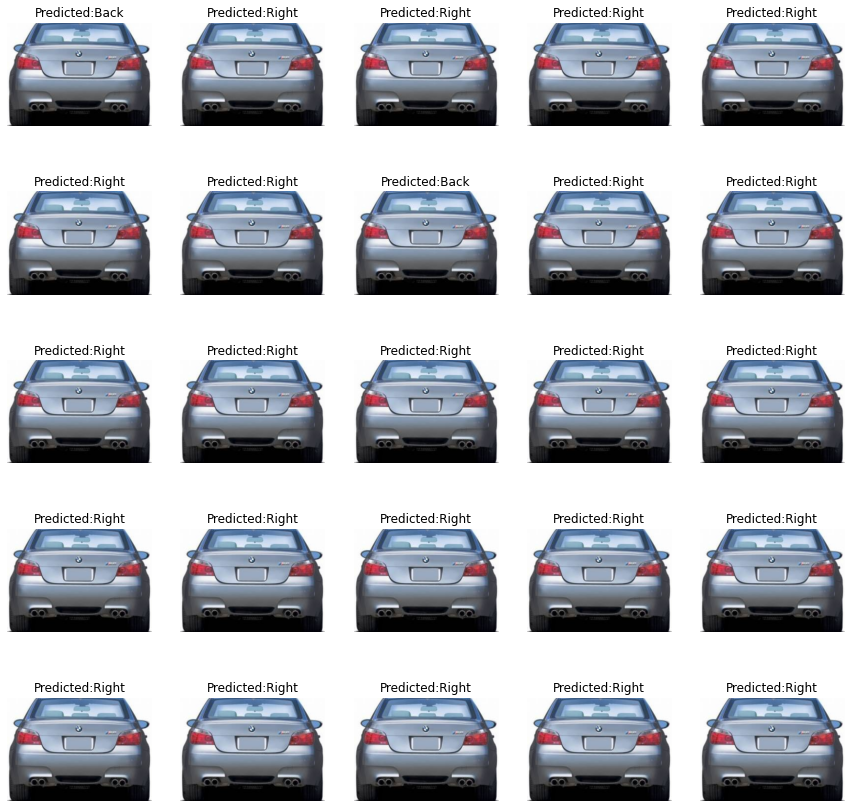

In [175]:
import matplotlib.pyplot as plt
import cv2

TEST_DIR = 'test_data_keras/test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + "00061.jpg")
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a i
    if predicted_class_indices[i] == 0:
        predicted_class = "Back"
    if predicted_class_indices[i] == 1:
        predicted_class = "Discard"
    if predicted_class_indices[i] == 2:
        predicted_class = "Front"
    if predicted_class_indices[i] == 3:
        predicted_class = "Left"
    if predicted_class_indices[i] == 4:
        predicted_class = "Right"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()